# **Hierarchical BERT**
The following notebook uses Hierarchical BERT (**HBERT**) with WordNet for word embeddings. It will also utilize a Combined User-defined Loss Functions (Focal Loss and Weighted Cross-Entropy Loss), and Temporal and Stock Data (which are the timestamp and stock name).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
)
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel

### (SHARED) Model and Dataset Parameters

In [2]:
from helpers import *
from models import train_hbert, WeightedFocalLoss

# Model hyperparameters
max_chunk_length = 256
max_chunks = 8
batch_size = 4
num_epochs = 45
learning_rate = 2e-5
aggregation_method = 'attention'
early_stopping_patience = 6
use_wordnet = True
focal_gamma = 2.0

# dataset and dataloaders
df = pd.read_csv(dataset_path)
train_datasets, val_datasets, test_datasets = get_split_datasets(
    df, use_wordnet=use_wordnet, max_chunk_length=max_chunk_length, max_chunks=max_chunks,
)
train_loader, train_df = train_datasets
val_loader, val_df = val_datasets
test_loader, test_df = test_datasets
num_stocks = len(df[stock].unique())

NLTK resource download complete


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thedu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\thedu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\thedu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\thedu\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\thedu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


CUDA device detected!

Train set: 2979 examples
Validation set: 590 examples
Test set: 615 examples

Testing WordNet enhancement...
Original: I bought my first $AAPL stock in 2010. Since then it has seen a 1,372.29% increase. Tell me again. W...
Enhanced: I bought my first $AAPL stock in 2010 . Since then it has have seen a 1,372.29% increase addition . ...

Original: Why can XPeng P5 deliver outstanding performance in extreme conditions? CEO He Xiaopeng explains the...
Enhanced: Why can tin XPeng P5 deliver outstanding performance in extreme conditions ? CEO He Xiaopeng explain...

Original: @TSM_Myth You dismantled me mentally and emotionally today [SEP] @TSM_Myth You did great! Dont be so...
Enhanced: @TSM_Myth You dismantled level me mentally and emotionally today [SEP] @TSM_Myth You did make great ...



# 1. HBERT Model

In [3]:
class HierarchicalBERTStockPredict(nn.Module):
    def __init__(
        self, num_labels=3, max_chunk_length=256, aggregation_method='attention',
        num_stocks=10, stock_embedding_dim=16
    ):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bert_hidden_size = self.bert.config.hidden_size

        self.bert_pooler = nn.Linear(self.bert_hidden_size, self.bert_hidden_size)
        self.bert_pooler_activation = nn.Tanh()
        self.aggregation_method = aggregation_method
        if aggregation_method == 'attention':
            self.attention = nn.Linear(self.bert_hidden_size, 1)

        self.temporal_embedding = nn.Linear(1, 32)
        self.temporal_activation = nn.Tanh()
        self.stock_embedding = nn.Embedding(num_stocks, stock_embedding_dim)
        combined_dim = self.bert_hidden_size + 32 + stock_embedding_dim

        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_labels)
        )
        self.max_chunk_length = max_chunk_length

    def forward(self, input_ids_list, attention_mask_list, time_values, stock_indices):
        batch_size = len(input_ids_list)
        chunk_embeddings = []

        for i in range(batch_size):
            example_chunks = []
            for j in range(len(input_ids_list[i])):
                out = self.bert(
                    input_ids=input_ids_list[i][j].unsqueeze(0), attention_mask=attention_mask_list[i][j].unsqueeze(0)
                )
                cls = out.last_hidden_state[:, 0, :]
                pooled = self.bert_pooler(cls)
                pooled = self.bert_pooler_activation(pooled)
                example_chunks.append(pooled)

            stacked = torch.cat(example_chunks, dim=0)
            if self.aggregation_method == 'mean':
                aggregated = torch.mean(stacked, dim=0, keepdim=True)
            elif self.aggregation_method == 'max':
                aggregated = torch.max(stacked, dim=0, keepdim=True)[0]
            elif self.aggregation_method == 'attention':
                attn_weights = torch.softmax(self.attention(stacked), dim=0)
                aggregated = torch.sum(stacked * attn_weights, dim=0, keepdim=True)
            chunk_embeddings.append(aggregated)

        text_embeddings = torch.cat(chunk_embeddings, dim=0)
        time_embeddings = self.temporal_activation(self.temporal_embedding(time_values.unsqueeze(1)))
        stock_embeddings = self.stock_embedding(stock_indices)

        combined = torch.cat([text_embeddings, time_embeddings, stock_embeddings], dim=1)
        combined = self.dropout(combined)
        return self.classifier(combined)

# 2. Model Training

### Model Training and Testing Results

In [6]:
model = HierarchicalBERTStockPredict(
    num_labels=num_labels, max_chunk_length=max_chunk_length,
    aggregation_method=aggregation_method, num_stocks=num_stocks
)
train_hbert(
    model, train_loader, test_loader, device, loss_fn=WeightedFocalLoss,
    num_epochs=num_epochs, learning_rate=learning_rate, focal_gamma=focal_gamma
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model and data prepared. Ready to train!
Epoch 1: Loss=122.8871, Accuracy=62.87%
Epoch 2: Loss=120.1918, Accuracy=62.54%
Epoch 3: Loss=117.7337, Accuracy=63.38%
Epoch 4: Loss=115.0399, Accuracy=65.36%
Epoch 5: Loss=106.0190, Accuracy=71.50%
Epoch 6: Loss=92.8865, Accuracy=77.34%
Epoch 7: Loss=70.0986, Accuracy=84.53%
Epoch 8: Loss=50.5681, Accuracy=90.10%
Epoch 9: Loss=37.6193, Accuracy=92.92%
Epoch 10: Loss=28.2947, Accuracy=94.46%
Epoch 11: Loss=23.9477, Accuracy=95.27%
Epoch 12: Loss=22.5064, Accuracy=95.64%
Epoch 13: Loss=22.3005, Accuracy=95.47%
Epoch 14: Loss=16.0172, Accuracy=96.61%
Epoch 15: Loss=15.5994, Accuracy=96.88%
Epoch 16: Loss=15.9627, Accuracy=97.31%
Epoch 17: Loss=16.9867, Accuracy=96.68%
Epoch 18: Loss=13.8988, Accuracy=97.15%
Epoch 19: Loss=14.6801, Accuracy=97.31%
Epoch 20: Loss=12.5251, Accuracy=97.38%
Epoch 21: Loss=12.9125, Accuracy=97.45%
Epoch 22: Loss=14.4830, Accuracy=97.28%
Epoch 23: Loss=11.3399, Accuracy=97.78%
Epoch 24: Loss=8.9360, Accuracy=98.22%
Epoc

### Save Model

In [5]:
# Save the trained model
save_dir = model_path + './hbert'

model_config = {
    'num_labels': model.classifier[-1].out_features,
    'max_chunk_length': model.max_chunk_length,
    'aggregation_method': model.aggregation_method,
    'num_stocks': model.stock_embedding.num_embeddings,
    'stock_embedding_dim': model.stock_embedding.embedding_dim
}
save_path = save_model(model, model_config, save_dir)
print(f"Model saved to: {save_path}")

Model successfully saved to .models./hbert
Model saved to: .models./hbert


In [8]:
save_dir = model_path + './hbert'
model, tokenizer = load_model(HierarchicalBERTStockPredict, save_dir)

Model successfully loaded from .models./hbert


# 3. In-depth Performance Evaluation

Skipping BX - insufficient test samples (4)
Skipping F - insufficient test samples (3)
Skipping NOC - insufficient test samples (3)

=== Overall Performance ===
Accuracy: 0.6098
F1 Score: 0.5936

Confusion Matrix:
[[283  83]
 [157  92]]

=== Stock Performance Ranking (by F1 Score) ===
Stock  Accuracy  Precision   Recall  F1 Score  Samples
   VZ  0.944444   1.000000 0.944444  0.971429     18.0
   KO  0.904762   0.818594 0.904762  0.859524     21.0
 INTC  0.880000   0.774400 0.880000  0.823830     25.0
   PG  0.837838   0.701972 0.837838  0.763911     37.0
 MSFT  0.702703   0.694566 0.702703  0.666856     37.0
 XPEV  0.666667   0.666667 0.666667  0.658009      9.0
  AMD  0.648649   0.645291 0.648649  0.646495     37.0
 GOOG  0.600000   0.617391 0.600000  0.590000     35.0
   BA  0.615385   0.630769 0.615385  0.585219     13.0
  NIO  0.567568   0.574680 0.567568  0.569475     37.0
 PYPL  0.611111   0.792593 0.611111  0.565589     18.0
  CRM  0.571429   0.539286 0.571429  0.544146     21.0

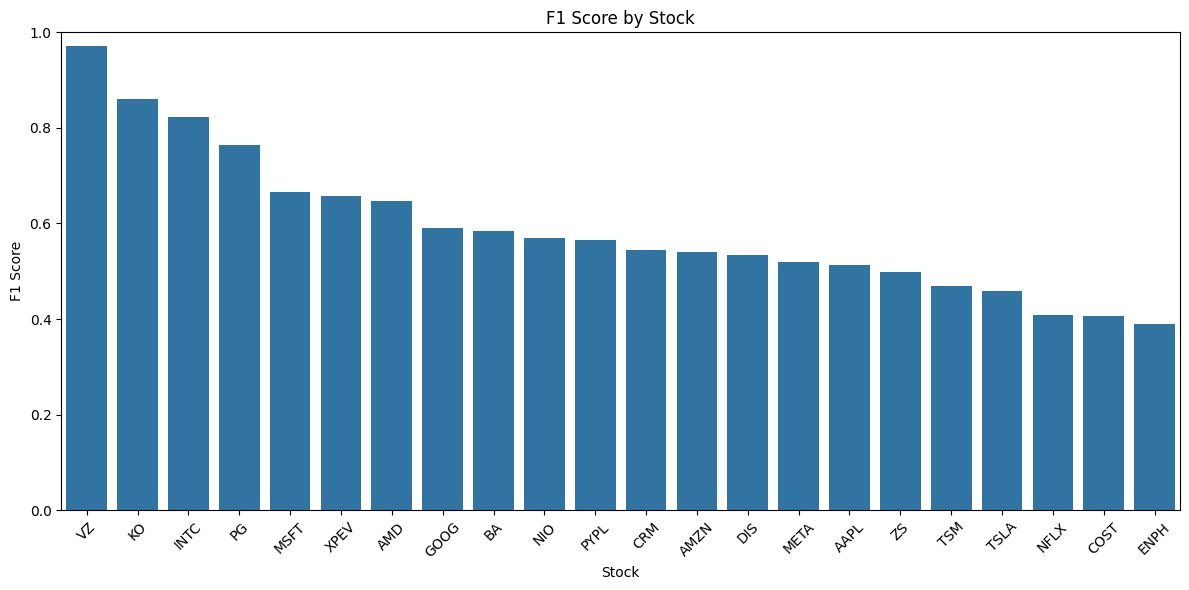

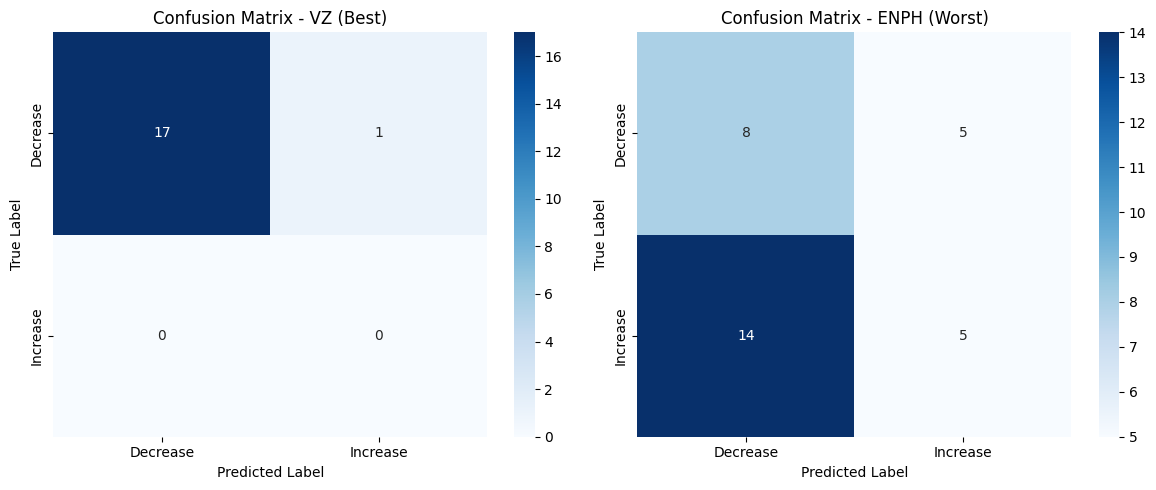


=== High Confidence Error Cases ===

Stock: META
Text: VR in entertainment allows the person to view 3D images making them realistic and enjoyable. Similarly, the $EPAZ slims' multiple nano webcams will cr...
True Label: Decrease
Predicted: Increase (Confidence: 1.00)
--------------------------------------------------

Stock: NFLX
Text: If I had to guess .Next $Fdx type play is $Nflx like last Friday 245c top watch for me $Cost watching for flush $Aapl 150/148 huge spots may have nice...
True Label: Decrease
Predicted: Increase (Confidence: 1.00)
--------------------------------------------------

Stock: NIO
Text: $NIO will soon be fully appreciated [SEP] Were excited to share that our NIOET7 has been recognized by @FastCompany as part of its 2022 Innovation by ...
True Label: Increase
Predicted: Decrease (Confidence: 1.00)
--------------------------------------------------

Stock: ENPH
Text: Put solar names on your watchlist for potential further upside. -Relative strength over the l

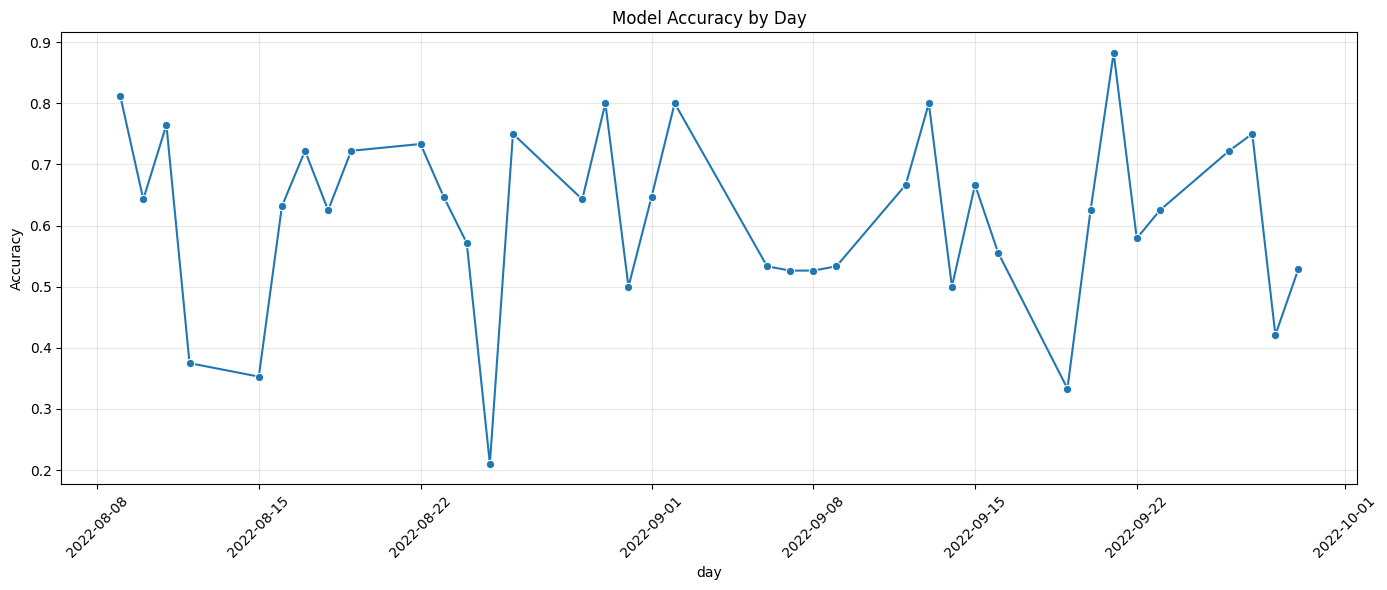

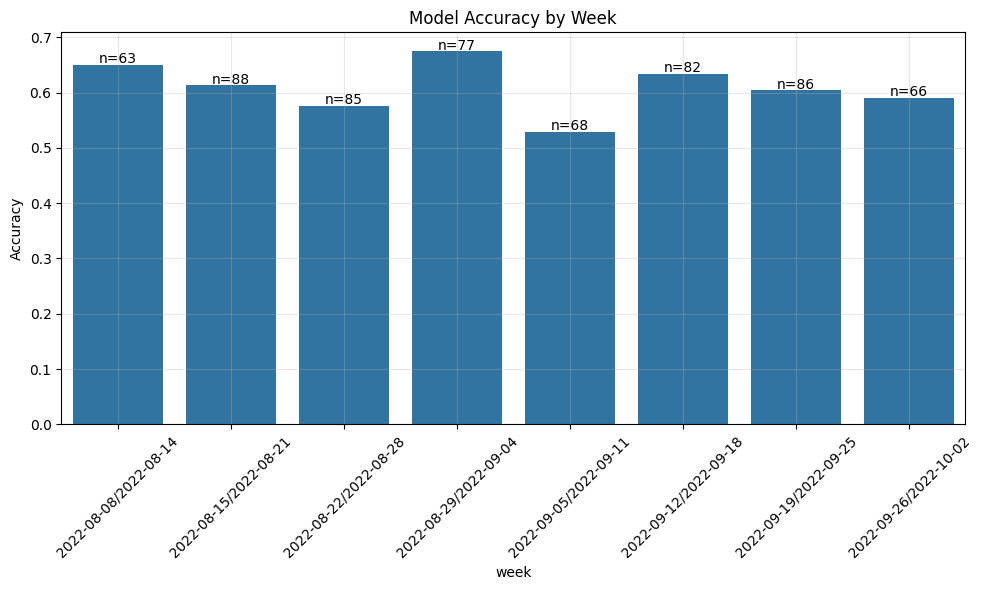


=== Worst Performing days ===
day: 2022-08-25 00:00:00, Accuracy: 0.21, Samples: 19
day: 2022-09-19 00:00:00, Accuracy: 0.33, Samples: 18
day: 2022-08-15 00:00:00, Accuracy: 0.35, Samples: 17


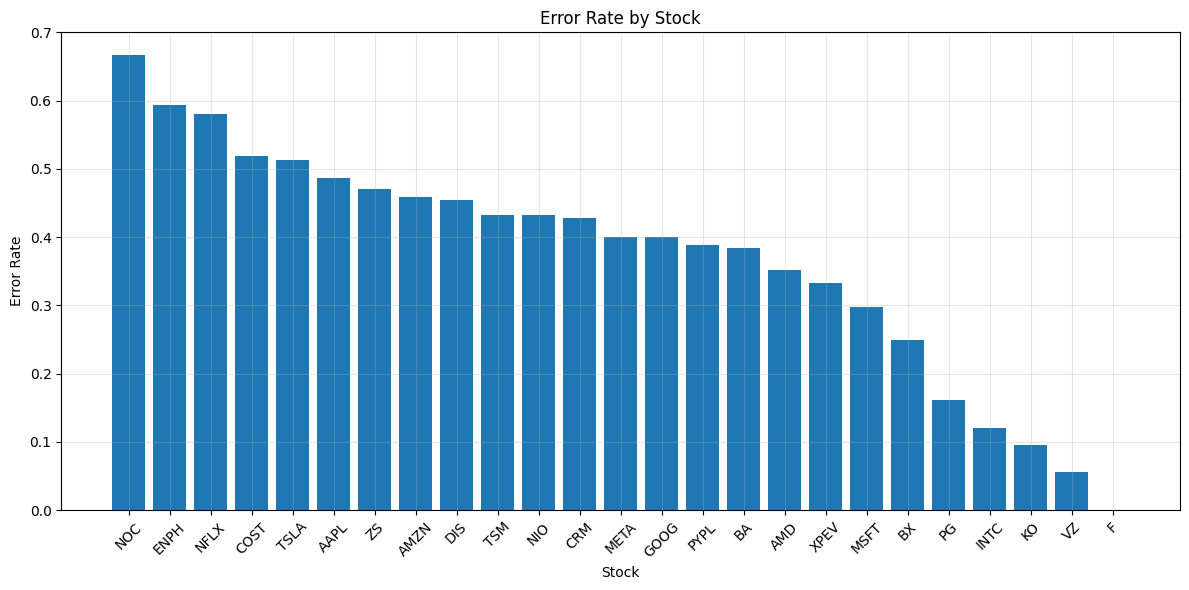


=== Stock-Specific Error Analysis ===

Stock: NOC - Error Rate: 0.67
Number of errors: 2 out of 3 samples
Common words in error cases:
  - 'noc': 2 occurrences
  - 'enph': 2 occurrences
  - 'averages': 1 occurrences
  - 'pulling': 1 occurrences
  - 'back': 1 occurrences
  - 'from': 1 occurrences
  - 'logical': 1 occurrences
  - 'supply': 1 occurrences
  - 'near': 1 occurrences

Example error cases:
  - True: Increase, Predicted: Decrease
    Text: Averages are pulling back from logical supply near their down trending 200-day lines. Biotech offered some powerful trades. Big cap stalwarts like $UN...

  - True: Increase, Predicted: Decrease
    Text: Today's noteworthy breakouts, moves, and setups: (stocks in trend sorted by relative volume) $AXNX, $ENPH, $PRVA, $EVH, $RS, $QLYS, $SRTS, $NOC, $AR, ...


Stock: ENPH - Error Rate: 0.59
Number of errors: 19 out of 32 samples
Common words in error cases:
  - 'enph': 32 occurrences
  - 'url': 25 occurrences
  - 'stocks': 17 occurrences

Exam

In [11]:
eval_results = evaluate_model_by_stock(
    model, test_loader, test_df, stock_column=stock, post_column=post
)

# run time-based analysis
print("\n\n=== Time-Based Performance Analysis ===")
_ = analyze_performance_by_time(eval_results['results_df'], date_column=date)

# run stock-specific error analysis
_ = analyze_stock_specific_errors(eval_results['results_df'], stock_column=stock, post_column=post)